In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import tensorflow as tf
tf.random.set_seed(123)


In [45]:
dateparse = lambda dates: pd.to_datetime(dates, format='%b/%Y')

consumo = pd.read_csv('consumo_normalizado.csv', parse_dates=['Fecha'], date_parser=dateparse)

print(consumo.head())

       Fecha  Aceites lubricantes  Asfalto     Bunker  Ceras  \
0 2000-01-01                  0.0  48446.0  296766.99    0.0   
1 2000-02-01                  0.0  50597.0  328116.44    0.0   
2 2000-03-01                  0.0  27593.0  368589.63    0.0   
3 2000-04-01                  0.0  53794.0  396300.47    0.0   
4 2000-05-01                  0.0  60137.0  449368.92    0.0   

   Combustible turbo jet  Diesel bajo azufre  Diesel ultra bajo azufre  \
0                    0.0                 0.0                       0.0   
1                    0.0                 0.0                       0.0   
2                    0.0                 0.0                       0.0   
3                    0.0                 0.0                       0.0   
4                    0.0                 0.0                       0.0   

   Gas licuado de petróleo  Gasolina de aviación  ...  Kerosina  \
0                194410.48                1426.0  ...  64026.09   
1                174710.55          

C:\Users\eunic\AppData\Local\Temp\ipykernel_27804\3670066919.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  consumo = pd.read_csv('consumo_normalizado.csv', parse_dates=['Fecha'], date_parser=dateparse)


In [46]:
consumo_regular = consumo[['Fecha', 'Gasolina regular']]
consumo_regular.set_index('Fecha', inplace=True)

consumo_regular.loc[:, 'Gasolina regular'] = consumo_regular['Gasolina regular'].interpolate()

ts_consumo_diff = consumo_regular['Gasolina regular'].diff()
ts_consumo_diff.fillna(0, inplace=True)

ts_consumo_diff_df = ts_consumo_diff.to_frame()

scaler = StandardScaler()
ts_consumo_scaled = scaler.fit_transform(ts_consumo_diff_df)

entrenamiento = round(0.6 * len(ts_consumo_scaled))
val_prueba = round(0.2 * len(ts_consumo_scaled))
test = ts_consumo_scaled[(entrenamiento+val_prueba)-1:]
validation = ts_consumo_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = ts_consumo_scaled[0:entrenamiento]
train = np.insert(train, 0, 0)
train = np.reshape(train, (train.shape[0], 1))

In [47]:
# Transformar a una serie supervisada
def supervisada(serie, retrasos=1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos), 0]
        valor_sig = serie[i+retrasos, 0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)




In [48]:
x_train, y_train = supervisada(train)
x_val, y_val = supervisada(validation)
x_test, y_test = supervisada(test)

# Ajustar las dimensiones para el modelo LSTM
x_train = np.reshape(x_train, (x_train.shape[0], 1, 1))
x_val = np.reshape(x_val, (x_val.shape[0], 1, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 1, 1))

In [49]:
modelo2 = Sequential()

modelo2.add(LSTM(units=50, return_sequences=True, input_shape=(1, 1)))
modelo2.add(LSTM(units=25))  # Segunda capa LSTM
modelo2.add(Dense(1))

modelo2.summary()

modelo2.compile(loss='mean_squared_error', optimizer="adam")

c:\Users\eunic\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 1, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,026 (70.41 KB)

 Trainable params: 18,026 (70.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3170 - val_loss: 0.9964
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3077 - val_loss: 0.9599
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2976 - val_loss: 0.9105
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2856 - val_loss: 0.8524
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2741 - val_loss: 0.8025
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2676 - val_loss: 0.7758
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2666 - val_loss: 0.7671
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2670 - val_loss: 0.7654
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2669 - val_loss: 0.7656
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2667 - val_loss: 0.7660
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2664 - val_loss: 0.7661
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

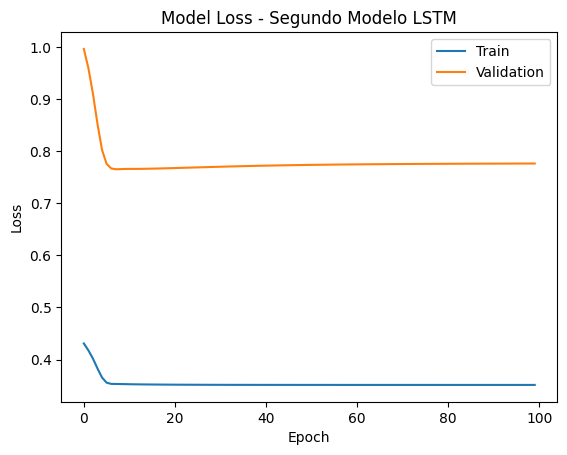

In [50]:
# Ajustar el modelo con un tamaño de lote mayor y más épocas
lote = 10  
epocas = 100  

history2 = modelo2.fit(
    x=x_train,
    y=y_train,
    batch_size=lote,
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val, y_val),
    verbose=1
)

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss - Segundo Modelo LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [51]:

def prediccion_fun(data, modelo, batch_size, scaler, dif=False, dif_cant=1, Series=None, n=1):
    prediccion = [0] * (len(data))
    i = 0
    for X in data:
        X = np.reshape(X, (1, 1, 1))
        yhat = modelo.predict(X, batch_size=batch_size, verbose=0)
        yhat = scaler.inverse_transform(yhat)
        if dif:
            yhat = yhat + Series[(n + dif_cant * i)]
        prediccion[i] = yhat[0][0]
        i += 1
    return prediccion


In [52]:
prediccion_val2 = prediccion_fun(x_val, modelo2, lote, scaler, dif=True, dif_cant=1, Series=consumo_regular.values, n=entrenamiento)
prediccion_test2 = prediccion_fun(x_test, modelo2, lote, scaler, dif=True, dif_cant=1, Series=consumo_regular.values, n=entrenamiento+val_prueba)


In [53]:
df_val2 = pd.DataFrame(prediccion_val2, index=consumo_regular[(entrenamiento):entrenamiento+val_prueba].index)
df_test2 = pd.DataFrame(prediccion_test2, index=consumo_regular[entrenamiento+len(df_val2):len(consumo_regular['Gasolina regular'])].index)

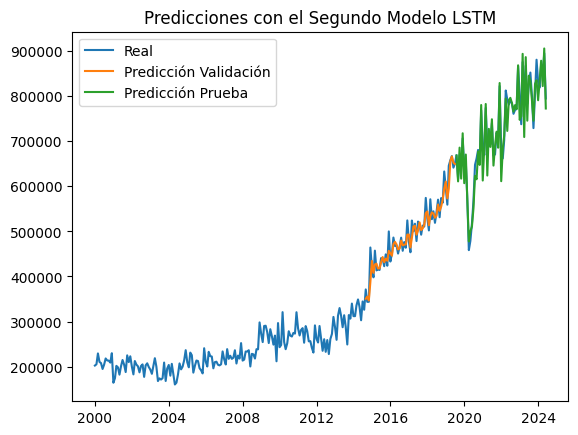

In [54]:
plt.plot(consumo_regular['Gasolina regular'], label='Real')
plt.plot(df_val2, label='Predicción Validación')
plt.plot(df_test2, label='Predicción Prueba')
plt.title('Predicciones con el Segundo Modelo LSTM')
plt.legend()
plt.show()